# Natural Computing

This is an exercise from 2019/2 period of the course "Natural Computing" at UFES, in Vitória/ES - Brazil.

Task: Compare different nature-inspired optimization algorithms.

Master's degree candidate: Bruno Carvalho

## Algorithms

- GA - Genetic Algorithms
- GP - Genetic Programming
- ES - Evolution Strategy
- DE - Differential Evolution

- PSO - Particle Swarm Optimization [Kennedy and Eberhart, 1995]
- ACO - Ant Colony Optimization [Korošec and Šilc, 2009]
- CS - Cuckoo Search
- GWO - Grey Wolf Optimizer
- MVO - Multi-Verse Optimizer
- MFO - Moth-flame Optimization 
- WOA - Whale Optimization Algorithm
- BAT - Bat Algorithm
- FFA - Firefly Algorithm

In [1]:
import os
import sys
import time
import itertools
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'


In [2]:
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [3]:
execution_dict = {
    'time_elapsed': 0,
    'algorithm': '',
    'metrics': {
        'best': [],
        'time': [],
        'objective': [],
        'scores': [],
    }
}

In [4]:
def ga_optimizer(obj_func, parameters):
    """

    Inspired by:
    https://github.com/7ossam81/EvoloPy/blob/master/GA.py

    """
    lower = parameters.get('lower', [-1.0])
    upper = parameters.get('upper', [1.0])
    dimension = parameters.get('dimension', 30)
    seed = parameters.get('seed', 1)
    max_iterations = parameters.get('max_iterations', 100)
    population = parameters.get('population', 100)
    crossover_rate = parameters.get('crossover_rate', 1.0)
    mutation_rate = parameters.get('mutation_rate', 0.01)
    best_to_keep = parameters.get('best_to_keep', 2)
    crossover_alpha = parameters.get('crossover_alpha', 0.25)
    
    np.random.seed(seed)
    
    # Input Objective function has variable dimensions
    # consider equi-distance "square"
    if not isinstance(lower, list):
        lower = [lower]
    if not isinstance(upper, list):
        upper = [upper]

    lower = lower * dimension
    upper = upper * dimension

    # track execution
    exec_info = execution_dict.copy()
    
    # allocate memory
    exec_info['metrics']['time'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['best'] = np.zeros([max_iterations, dimension], dtype='float')
    exec_info['metrics']['objective'] = np.zeros([max_iterations], dtype='float')
    exec_info['metrics']['scores'] = np.zeros([max_iterations, population], dtype='float')
    #exec_info['metrics']['scores'] = np.zeros([max_iterations, population], dtype='float')

    begin = time.time()

    # search space - Zero init array
    #space = np.full([population, dimension], 0.0)
    space = np.random.uniform(0, 1, [population, dimension])

    # objective evaluation scores
    scores = np.random.uniform(0.0, 1.0, population)
    
    beta = np.random.uniform(-crossover_alpha, 1 + crossover_alpha)

    def crossover(space, scores):
        search_space = np.zeros_like(space)
        search_space[0:best_to_keep, :] = space[0:best_to_keep, :]
        #beta = np.random.uniform(-crossover_alpha, 1 + crossover_alpha)
        
        for cross  in range(best_to_keep + 1, population - best_to_keep, 2):
            # ARITHMETIC CROSSOVER
            # random select 2 partents
            parents = set()
            
            while len(parents) < 2:
                parent1_idx = np.random.randint(0, population)
                parent2_idx = np.random.randint(0, population)
            
                if scores[parent1_idx] > scores[parent2_idx]:
                    # p1 is better then p2
                    parents.add(parent1_idx)
                else:
                    parents.add(parent2_idx)               
            
            lp = list(parents)
            #print(cross, lp, parents,parent1_idx, parent2_idx, parent3_idx, parent4_idx)
            parent1 = space[lp[0], :]
            parent2 = space[lp[1], :]
            
            child1 = parent1 * beta + (1.0 - beta) * parent2
            child2 = parent2 * beta + (1.0 - beta) * parent1
            
            crossover_chance = np.random.uniform(0.0, 1.0)
            if crossover_chance < crossover_rate:
                search_space[cross, :] = np.copy(child1)
                search_space[cross + 1, :] = np.copy(child2)  
            else:
                search_space[cross, :] = np.copy(parent1)
                search_space[cross + 1, :] = np.copy(parent2)
        """

        for cross  in range(best_to_keep + 1, population):
            # ARITHMETIC CROSSOVER
            # random select 2 partents
            parents = set()
            
            while len(parents) < 2:
                parent1_idx = np.random.randint(0, population)
                parent2_idx = np.random.randint(0, population)
            
                if scores[parent1_idx] > scores[parent2_idx]:
                    # p1 is better then p2
                    parents.add(parent1_idx)
                else:
                    parents.add(parent2_idx)               
            
            lp = list(parents)
            #print(cross, lp, parents,parent1_idx, parent2_idx, parent3_idx, parent4_idx)
            parent1 = space[lp[0], :]
            parent2 = space[lp[1], :]
            
            child1 = parent1 * beta + (1.0 - beta) * parent2
            child2 = parent2 * beta + (1.0 - beta) * parent1
            
            crossover_chance = np.random.uniform(0.0, 1.0)
            if crossover_chance < crossover_rate:
                search_space[cross, :] = np.copy(child1)
            else:
                search_space[cross, :] = np.copy(parent1)
        """
                
        return search_space
    
    def mutation(space, gen):
        n_mutate = np.int(population * mutation_rate)
        for m in range(n_mutate):
            rand_individual = np.random.randint(best_to_keep + 1, population)
            #stdev = 5.0 / np.sqrt(gen)
            stdev = 2
            new_value = np.zeros(dimension)
            for j in range(dimension):
                new_value[j] = np.random.normal(space[rand_individual, j], stdev)
            new_value = np.clip(new_value, lower, upper)
            #print(m, n_mutate, gen, i, mutation_rate)
            #print('old', space[rand_individual, :])
            #print('new', new_value)

            # store
            space[rand_individual, :] = new_value

        """
        # population MUST be already sorted from best to worst
        for i  in range(best_to_keep + 1, population):
            chance = np.random.uniform(0.0, 1.0)
            if chance <= mutation_rate:
                # select WHICH individual will be mutated
                # uniform distribution = all have the same chance to be selected
                rand_individual = np.random.randint(0, dimension)
                
                # new value = GAUSS from current point, STD_DEV smaller with generations
                #stdev = 5.0 / np.sqrt(gen)
                stdev = 2
                #mean = space[rand_individual, :].mean()
                #new_value = np.random.normal(space[rand_individual, :], np.full(5/gen, [dimension, 1])
                new_value = np.zeros(dimension)
                for j in range(dimension):
                    new_value[j] = np.random.normal(space[rand_individual, j], stdev)
                new_value = np.clip(new_value, lower, upper)
                print(gen, i, chance, mutation_rate)
                print('old', space[rand_individual, :])
                print('new', new_value)
                
                # store
                space[rand_individual, :] = new_value
        """

        return space
    
    def sort_iter(_space, _scores):
        idx = scores.argsort()
        _space = _space[idx]
        _scores = _scores[idx]
        return _space, _scores
    
    def eval_obj(func, _space):
        _scores = np.zeros(population)
        for d in range(dimension):
            _space[:, d] = np.clip(_space[:, d], lower[d], upper[d])
        for p in range(population):
            _scores[p] = func(_space[p, :])
        return scores

    for i in range(dimension):
        space[:, i] = np.random.uniform(0, 1, population) * (upper[i] - lower[i]) + lower[i]
        #space[:, i] = space[:, i] * (upper[i] - lower[i]) + lower[i]
    
    for _iter in range(1, max_iterations):
        
        # crossover
        space = crossover(space, scores)
        
        # mutation
        space = mutation(space, _iter)
        
        # evaluate objective
        scores = eval_obj(obj_func, space)
        
        # remove duplicates
        
        # sort
        space, scores = sort_iter(space, scores)
        
        # save
        exec_info['metrics']['scores'][_iter] = scores
        exec_info['metrics']['time'][_iter] = time.time() - begin
        exec_info['metrics']['best'][_iter] = space[0, :]
        
        if _iter % 1000 == 0:
            print(f'\tGeneration {_iter:06d}, best_value={scores[0]:+12.7e}')

    exec_info['algorithm'] = 'GA - Genetic Algorithm'
    exec_info['time_elapsed'] = time.time() - begin
    
    return exec_info

In [5]:
def ackley_function(x):
    n = x.shape[0]
    exp1 = -0.2 * np.sqrt(1/n) * np.dot(x.T, x)
    exp2 = np.sum(np.cos(2 * np.pi * x)) / n
    return np.squeeze(-20 * np.exp(exp1) - np.exp(exp2) + 20 + np.e)

In [6]:
params = {
    'seed': 5
}
results = []

for _dim in range(2, 30 + 1):
    params = {
        'seed': 1,
        'dimension': _dim,
        'max_iterations': 5,
        'population': 1000,
        'upper': [30],
        'lower': [-30],
    }
    print(f'Dimensions: {_dim}')
    ga_result = ga_optimizer(ackley_function, params)
    results.append(ga_result.copy())
    print(f"\tTop 5 f(x) values, after {ga_result['time_elapsed']:7.2f}s")
    print('\tf=', ga_result['metrics']['scores'][-1][:5])
    print('\tx=')
    for xv in ga_result['metrics']['best'][-1]:
        print(f'\t\t {xv:+12.7e}')


Dimensions: 2
	Top 5 f(x) values, after    0.06s
	f= [0.00111483 0.00196365 0.00250756 0.00426502 0.00487205]
	x=
		 -1.6595360e+01
		 -2.2117960e+01
Dimensions: 3
	Top 5 f(x) values, after    0.06s
	f= [9.69506877e-05 3.98380055e-04 7.40912961e-04 7.86541530e-04
 2.00030061e-03]
	x=
		 -1.0786824e+01
		 -1.0727595e+01
		 -1.5802763e+01
Dimensions: 4
	Top 5 f(x) values, after    0.06s
	f= [0.00014133 0.000393   0.00097781 0.00150447 0.00468674]
	x=
		 +1.8039751e+01
		 +8.3847044e+00
		 +6.8385964e-01
		 -5.5969605e+00
Dimensions: 5
	Top 5 f(x) values, after    0.06s
	f= [0.00060864 0.00149976 0.00180963 0.0018308  0.00242369]
	x=
		 -1.1459992e+01
		 -8.6837612e+00
		 +8.7840966e+00
		 -5.3963479e+00
		 -1.4157888e+01
Dimensions: 6
	Top 5 f(x) values, after    0.06s
	f= [0.0042513  0.00569318 0.00736889 0.00773199 0.00782859]
	x=
		 -2.3046779e+01
		 +5.3495473e+00
		 -5.3468123e+00
		 +2.3036358e+01
		 +2.5012970e+01
		 +3.4691082e+00
Dimensions: 7
	Top 5 f(x) values, after    0.06s


In [7]:
#for key in ga_result:
#    print('\t', key, ':', ga_result[key])

In [8]:
dim = 2
r_dim = results[0]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2][0])

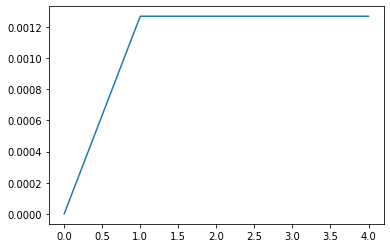

In [9]:
plt.plot(y_plot)

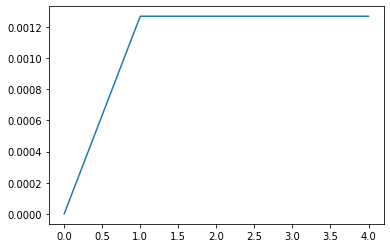

In [10]:
dim = 30
r_dim = results[dim - 2]
y_plot = []
for _iter2 in range(r_dim['metrics']['scores'].shape[0]):
    y_plot.append(r_dim['metrics']['scores'][_iter2][0])
plt.plot(y_plot)